In [2]:
import os
import sys
import skimage.io as io
import random
import json
import pickle

import math
import numpy as np
from collections import Counter
import nltk
nltk.download('punkt')
import torch
import torch.utils.data as DataSet
from pycocotools.coco import COCO

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from importlib import reload

sys.path.insert(0, '../src')
import DataPreperation
%matplotlib inline

[nltk_data] Downloading package punkt to /home/nboren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Model

In [3]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        ''' Initialize the layers of this model.'''
        super().__init__()
    
        # Keep track of hidden_size for initialization of hidden state
        self.hidden_size = hidden_size
        
        # Embedding layer that turns words into a vector of a specified size
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        
        # The LSTM takes embedded word vectors (of a specified size) as input
        # and outputs hidden states of size hidden_dim
        self.lstm = nn.LSTM(input_size=embed_size, \
                            hidden_size=hidden_size, # LSTM hidden units 
                            num_layers=1, # number of LSTM layer
                            bias=True, # use bias weights b_ih and b_hh
                            batch_first=True,  # input & output will have batch size as 1st dimension
                            dropout=0, # Not applying dropout 
                            bidirectional=False, # unidirectional LSTM
                           )
        
        # The linear layer that maps the hidden state output dimension
        # to the number of words we want as output, vocab_size
        self.linear = nn.Linear(hidden_size, vocab_size)                     

        # initialize the hidden state
        # self.hidden = self.init_hidden()


    def init_hidden(self, batch_size):
      """ At the start of training, we need to initialize a hidden state;
      there will be none because the hidden state is formed based on previously seen data.
      So, this function defines a hidden state with all zeroes
      The axes semantics are (num_layers, batch_size, hidden_dim)
      """
      return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
              torch.zeros((1, batch_size, self.hidden_size), device=device))
    

    def forward(self, features, captions):
      """ Define the feedforward behavior of the model """
      
      # Discard the <end> word to avoid predicting when <end> is the input of the RNN
      captions = captions[:, :-1]     
      
      # Initialize the hidden state
      batch_size = features.shape[0] # features is of shape (batch_size, embed_size)
      self.hidden = self.init_hidden(batch_size) 
              
      # Create embedded word vectors for each word in the captions
      embeddings = self.word_embeddings(captions) # embeddings new shape : (batch_size, captions length - 1, embed_size)
      
      # Stack the features and captions
      embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1) # embeddings new shape : (batch_size, caption length, embed_size)
      
      # Get the output and hidden state by passing the lstm over our word embeddings
      # the lstm takes in our embeddings and hidden state
      lstm_out, self.hidden = self.lstm(embeddings, self.hidden) # lstm_out shape : (batch_size, caption length, hidden_size)

      # Fully connected layer
      outputs = self.linear(lstm_out) # outputs shape : (batch_size, caption length, vocab_size)

      return outputs


    ## Greedy search 
    def sample(self, inputs):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        
        
        output = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
            outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
            outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)
            _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)
            
            output.append(max_indice.cpu().numpy()[0].item()) # storing the word predicted
            
            if (max_indice == 1):
                # We predicted the <end> word, so there is no further prediction to do
                break
            
            ## Prepare to embed the last predicted word to be the new input of the lstm
            inputs = self.word_embeddings(max_indice) # inputs shape : (1, embed_size)
            inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)
            
        return output


    ## Beam search implementation (Attempt)
    def beam_search_sample(self, inputs, beam=3):
        output = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
        
        # sequences[0][0] : index of start word
        # sequences[0][1] : probability of the word predicted
        # sequences[0][2] : hidden state related of the last word
        sequences = [[[torch.Tensor([0])], 1.0, hidden]]
        max_len = 20

        ## Step 1
        # Predict the first word <start>
        outputs, hidden = DecoderRNN.get_outputs(self, inputs, hidden)
        _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)
        output.append(max_indice.cpu().numpy()[0].item()) # storing the word predicted 
        # inputs = DecoderRNN.get_next_word_input(self, max_indice)
        
        
        l = 0
        while len(sequences[0][0]) < max_len: 
            print("l:", l)
            l+= 1
            temp = []
            for seq in sequences:
#                 print("seq[0]: ", seq[0])
                inputs = seq[0][-1] # last word index in seq
                inputs = inputs.type(torch.cuda.LongTensor)
                print("inputs : ", inputs)
                # Embed the input word
                inputs = self.word_embeddings(inputs) # inputs shape : (1, embed_size)
                inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size) 
                
                # retrieve the hidden state
                hidden = seq[2]
                
                preds, hidden = DecoderRNN.get_outputs(self, inputs, hidden)

                # Getting the top <beam_index>(n) predictions
                softmax_score = F.log_softmax(outputs, dim=1) # Define a function to sort the cumulative score
                sorted_score, indices = torch.sort(-softmax_score, dim=1)
                word_preds = indices[0][:beam]
                best_scores = sorted_score[0][:beam]

                # Creating a new list so as to put them via the model again
                for i, w in enumerate(word_preds):
#                     print("seq[0]: ", seq[0][0][:].cpu().numpy().item())
                    next_cap, prob = seq[0][0].cpu().numpy().tolist(), seq[1]
                    
                    next_cap.append(w)
                    print("next_cap : ", next_cap)
                    prob *best_scores[i].cpu().item()
                    temp.append([next_cap, prob])

            sequences = temp
            # Order according to proba
            ordered = sorted(sequences, key=lambda tup: tup[1])

            # Getting the top words
            sequences = ordered[:beam]
            print("sequences: ", sequences)


    def get_outputs(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
        outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
        outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)

        return outputs, hidden


    def get_next_word_input(self, max_indice):
        ## Prepare to embed the last predicted word to be the new input of the lstm
        inputs = self.word_embeddings(max_indice) # inputs shape : (1, embed_size)
        inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)

        return inputs

# Training Exploration

In [4]:
from torchvision import transforms
import DataPreperation
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 6

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = DataPreperation.get_loader(transform=transform_train,
                         vocab_file='./word_vocab.pkl',
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         use_word_vocab=True)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


KeyboardInterrupt: 

In [5]:

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = DataSet.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))

# Specify the dimensionality of the image embedding.
embed_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images (from Step 2) to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that your encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."



# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
decoder.to(device)
    
# Move last batch of captions (from Step 1) to GPU if CUDA is available 
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

# Check that your decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder is incorrect."

NameError: name 'data_loader' is not defined

# LSTM Decoder on Word Embeddings

In [7]:
batch_size = 32
vocab_threshold = 6 
vocab_from_file = True  
embed_size = 512
hidden_size = 512 
num_epochs = 10 
save_every = 1         
print_every = 200         
log_file = 'training_log.txt'     

transform_train = transforms.Compose([ 
    transforms.Resize(256),                         
    transforms.RandomCrop(224),                   
    transforms.RandomHorizontalFlip(),          
    transforms.ToTensor(),                     
    transforms.Normalize((0.485, 0.456, 0.406),     
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = DataPreperation.get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         use_word_vocab=True)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.resnet.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

/mnt/c/Users/Nickb/PycharmProjects/Image-Captioning/notebooks
./word_vocab.pkl
Word Vocabulary successfully loaded from ./word_vocab.pkl file
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:44<00:00, 13160.47it/s]


In [11]:
print(device)

cuda


In [10]:
import requests
import time
from tqdm import tqdm

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
#response = requests.request("GET", 
                            #"http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            #headers={"Metadata-Flavor":"Google"})

for epoch in tqdm(range(1, num_epochs+1)):
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB") 
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            #requests.request("POST", 
                             #"https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             #headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = DataSet.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler

        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()

          # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('../models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('../models', 'encoder-%d.pkl' % epoch))
                              
    
# Close the training log file.
f.close()

  0%|          | 0/10 [00:00<?, ?it/s]

Allocated: 0.3 GB
Epoch [1/10], Step [200/18493], Loss: 3.1863, Perplexity: 24.1976
Epoch [1/10], Step [400/18493], Loss: 3.0632, Perplexity: 21.3965
Epoch [1/10], Step [600/18493], Loss: 3.2820, Perplexity: 26.6283
Epoch [1/10], Step [800/18493], Loss: 2.7876, Perplexity: 16.2423
Epoch [1/10], Step [1000/18493], Loss: 3.2224, Perplexity: 25.0878
Epoch [1/10], Step [1200/18493], Loss: 2.4982, Perplexity: 12.1610
Epoch [1/10], Step [1400/18493], Loss: 2.8412, Perplexity: 17.1356
Epoch [1/10], Step [1600/18493], Loss: 2.7280, Perplexity: 15.30285
Epoch [1/10], Step [1800/18493], Loss: 2.5100, Perplexity: 12.3050
Epoch [1/10], Step [2000/18493], Loss: 2.6695, Perplexity: 14.4322
Epoch [1/10], Step [2200/18493], Loss: 2.5038, Perplexity: 12.2285
Epoch [1/10], Step [2400/18493], Loss: 2.5931, Perplexity: 13.3708
Epoch [1/10], Step [2600/18493], Loss: 2.5965, Perplexity: 13.4169
Epoch [1/10], Step [2800/18493], Loss: 3.5589, Perplexity: 35.1251
Epoch [1/10], Step [3000/18493], Loss: 2.3448, 

 10%|█         | 1/10 [2:48:00<25:12:04, 10080.48s/it]

Allocated: 0.3 GB
Epoch [2/10], Step [200/18493], Loss: 2.9491, Perplexity: 19.0880
Epoch [2/10], Step [400/18493], Loss: 2.4301, Perplexity: 11.3599
Epoch [2/10], Step [600/18493], Loss: 1.9529, Perplexity: 7.04898
Epoch [2/10], Step [800/18493], Loss: 2.1318, Perplexity: 8.42990
Epoch [2/10], Step [1000/18493], Loss: 1.9987, Perplexity: 7.3795
Epoch [2/10], Step [1200/18493], Loss: 2.0167, Perplexity: 7.51373
Epoch [2/10], Step [1400/18493], Loss: 2.6463, Perplexity: 14.1011
Epoch [2/10], Step [1600/18493], Loss: 2.3712, Perplexity: 10.7107
Epoch [2/10], Step [1800/18493], Loss: 2.1049, Perplexity: 8.20608
Epoch [2/10], Step [2000/18493], Loss: 2.1064, Perplexity: 8.21838
Epoch [2/10], Step [2200/18493], Loss: 2.2793, Perplexity: 9.76991
Epoch [2/10], Step [2400/18493], Loss: 2.2246, Perplexity: 9.24991
Epoch [2/10], Step [2600/18493], Loss: 2.2759, Perplexity: 9.73708
Epoch [2/10], Step [2800/18493], Loss: 2.0669, Perplexity: 7.90023
Epoch [2/10], Step [3000/18493], Loss: 2.2343, Pe

 20%|██        | 2/10 [5:34:29<22:16:52, 10026.56s/it]

Allocated: 0.3 GB
Epoch [3/10], Step [200/18493], Loss: 2.3154, Perplexity: 10.1286
Epoch [3/10], Step [400/18493], Loss: 1.9722, Perplexity: 7.18632
Epoch [3/10], Step [600/18493], Loss: 2.5772, Perplexity: 13.1608
Epoch [3/10], Step [800/18493], Loss: 2.2659, Perplexity: 9.64030
Epoch [3/10], Step [1000/18493], Loss: 1.8321, Perplexity: 6.2471
Epoch [3/10], Step [1200/18493], Loss: 1.5846, Perplexity: 4.87746
Epoch [3/10], Step [1400/18493], Loss: 2.0127, Perplexity: 7.48324
Epoch [3/10], Step [1600/18493], Loss: 1.8155, Perplexity: 6.14410
Epoch [3/10], Step [1800/18493], Loss: 2.0035, Perplexity: 7.41497
Epoch [3/10], Step [2000/18493], Loss: 2.1286, Perplexity: 8.40348
Epoch [3/10], Step [2200/18493], Loss: 2.6644, Perplexity: 14.3598
Epoch [3/10], Step [2400/18493], Loss: 2.0730, Perplexity: 7.94871
Epoch [3/10], Step [2600/18493], Loss: 1.7629, Perplexity: 5.82938
Epoch [3/10], Step [2800/18493], Loss: 2.1827, Perplexity: 8.86986
Epoch [3/10], Step [3000/18493], Loss: 1.9495, Pe

 30%|███       | 3/10 [8:22:12<19:31:43, 10043.41s/it]

Allocated: 0.3 GB
Epoch [4/10], Step [200/18493], Loss: 2.6572, Perplexity: 14.2567
Epoch [4/10], Step [400/18493], Loss: 1.8791, Perplexity: 6.54734
Epoch [4/10], Step [600/18493], Loss: 1.9521, Perplexity: 7.04315
Epoch [4/10], Step [800/18493], Loss: 1.9232, Perplexity: 6.84314
Epoch [4/10], Step [1000/18493], Loss: 3.7966, Perplexity: 44.5474
Epoch [4/10], Step [1200/18493], Loss: 2.2309, Perplexity: 9.30816
Epoch [4/10], Step [1400/18493], Loss: 2.1154, Perplexity: 8.29265
Epoch [4/10], Step [1600/18493], Loss: 1.9659, Perplexity: 7.14157
Epoch [4/10], Step [1800/18493], Loss: 2.3097, Perplexity: 10.0719
Epoch [4/10], Step [2000/18493], Loss: 1.7545, Perplexity: 5.78085
Epoch [4/10], Step [2200/18493], Loss: 2.0180, Perplexity: 7.52333
Epoch [4/10], Step [2400/18493], Loss: 2.2003, Perplexity: 9.02791
Epoch [4/10], Step [2600/18493], Loss: 2.0610, Perplexity: 7.85384
Epoch [4/10], Step [2800/18493], Loss: 1.9378, Perplexity: 6.94331
Epoch [4/10], Step [3000/18493], Loss: 1.8516, P

 30%|███       | 3/10 [9:08:04<21:18:51, 10961.58s/it]


KeyboardInterrupt: 

# LSTM on Char Encodings

In [18]:
batch_size = 10 
vocab_threshold = 6 
vocab_from_file = True 
vocab_file = './char_vocab.pkl'
embed_size = 512
hidden_size = 512          
num_epochs = 1          
save_every = 1             
print_every = 200  
log_file = 'char_training_log.txt'  


transform_train = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.RandomCrop(224),                      
    transforms.RandomHorizontalFlip(),               
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = DataPreperation.get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_file=vocab_file,
                         vocab_from_file=vocab_from_file,
                         use_word_vocab=False)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.resnet.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Char Vocabulary successfully loaded from ./char_vocab.pkl file
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:53<00:00, 11074.76it/s]


In [19]:
for epoch in tqdm(range(1, num_epochs+1)):
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB") 
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            #requests.request("POST", 
                             #"https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             #headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = DataSet.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler

        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        if epoch % print_every == 0:
            print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB") 
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()

          # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('../models', 'char_decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('../models', 'char_encoder-%d.pkl' % epoch))
                              
    
# Close the training log file.
f.close()

  0%|          | 0/1 [00:00<?, ?it/s]

Allocated: 0.3 GB
Epoch [1/1], Step [200/59176], Loss: 0.5831, Perplexity: 1.7916
Epoch [1/1], Step [400/59176], Loss: 0.4380, Perplexity: 1.5496
Epoch [1/1], Step [600/59176], Loss: 0.4708, Perplexity: 1.6013
Epoch [1/1], Step [800/59176], Loss: 0.2650, Perplexity: 1.3035
Epoch [1/1], Step [1000/59176], Loss: 0.5286, Perplexity: 1.6966
Epoch [1/1], Step [1200/59176], Loss: 0.4705, Perplexity: 1.6008
Epoch [1/1], Step [1400/59176], Loss: 0.4908, Perplexity: 1.6336
Epoch [1/1], Step [1600/59176], Loss: 0.5938, Perplexity: 1.8108
Epoch [1/1], Step [1800/59176], Loss: 0.3845, Perplexity: 1.4689
Epoch [1/1], Step [2000/59176], Loss: 0.5171, Perplexity: 1.6771
Epoch [1/1], Step [2200/59176], Loss: 0.3833, Perplexity: 1.4672
Epoch [1/1], Step [2400/59176], Loss: 0.4127, Perplexity: 1.5108
Epoch [1/1], Step [2600/59176], Loss: 0.4571, Perplexity: 1.5795
Epoch [1/1], Step [2800/59176], Loss: 0.4363, Perplexity: 1.5469
Epoch [1/1], Step [3000/59176], Loss: 0.4255, Perplexity: 1.5304
Epoch [1/1]

Epoch [1/1], Step [49800/59176], Loss: 0.4857, Perplexity: 1.6253
Epoch [1/1], Step [50000/59176], Loss: 0.3927, Perplexity: 1.4809
Epoch [1/1], Step [50200/59176], Loss: 0.3645, Perplexity: 1.4398
Epoch [1/1], Step [50400/59176], Loss: 0.4111, Perplexity: 1.5084
Epoch [1/1], Step [50600/59176], Loss: 0.4178, Perplexity: 1.5186
Epoch [1/1], Step [50800/59176], Loss: 0.4226, Perplexity: 1.5260
Epoch [1/1], Step [51000/59176], Loss: 0.4304, Perplexity: 1.5379
Epoch [1/1], Step [51200/59176], Loss: 0.3953, Perplexity: 1.4849
Epoch [1/1], Step [51400/59176], Loss: 0.5336, Perplexity: 1.7051
Epoch [1/1], Step [51600/59176], Loss: 0.4236, Perplexity: 1.5275
Epoch [1/1], Step [51800/59176], Loss: 0.4218, Perplexity: 1.5246
Epoch [1/1], Step [52000/59176], Loss: 0.5021, Perplexity: 1.6522
Epoch [1/1], Step [52200/59176], Loss: 0.4321, Perplexity: 1.5406
Epoch [1/1], Step [52400/59176], Loss: 0.5414, Perplexity: 1.7185
Epoch [1/1], Step [52600/59176], Loss: 0.7378, Perplexity: 2.0913
Epoch [1/1

100%|██████████| 1/1 [5:01:04<00:00, 18064.89s/it]


# Generating Predictions

In [21]:
from importlib import reload

[nltk_data] Downloading package punkt to /home/nboren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'DataPreperation' from '/mnt/c/Users/Nickb/PycharmProjects/Image-Captioning/notebooks/../src/DataPreperation.py'>

In [31]:
reload(DataPreperation)

[nltk_data] Downloading package punkt to /home/nboren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'DataPreperation' from '/mnt/c/Users/Nickb/PycharmProjects/Image-Captioning/notebooks/../src/DataPreperation.py'>

In [32]:
transform_test = transforms.Compose([transforms.Resize((224, 224)), \
                                     transforms.ToTensor(), \
                                     transforms.Normalize((0.485, 0.456, 0.406), \
                                                          (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = DataPreperation.get_loader(transform=transform_test,    
                         mode='test')

/mnt/c/Users/Nickb/PycharmProjects/Image-Captioning/notebooks
./word_vocab.pkl
Word Vocabulary successfully loaded from ./word_vocab.pkl file


In [33]:
# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl' 
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('../models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('../models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (word_embeddings): Embedding(9438, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9438, bias=True)
)

In [34]:
def clean_sentence(output):
    list_string = []
    
    for idx in output:
        list_string.append(data_loader.dataset.vocab.idx2word[idx])
    
    list_string = list_string[1:-1] # Discard  and  words
    sentence = ' '.join(list_string) # Convert list of string to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    return sentence

In [35]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

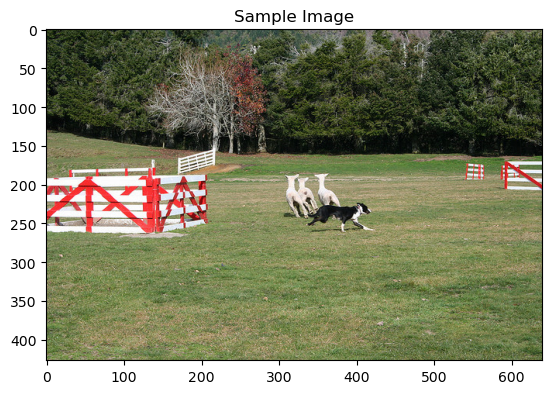

A couple of sheep are standing on a grass field .


In [43]:
get_prediction()